The cells were executed already, so you can just read through the notebook. Be aware that it can be quite long to run the cells on your computer.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

---
### Wide and deep network from last TD

Define the basic rectangle network.

In [2]:
class Net(nn.Module):
    def __init__(self, n_layers=1, n_hidden=3):
        super(Net, self).__init__()
        self.fc_in = nn.Linear(1, n_hidden)
        self.fcs = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for i in range(n_layers-1)])
        self.fc_out = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x = F.relu(self.fc_in(x))
        for i in range(len(self.fcs)):
            x = F.relu(self.fcs[i](x))
        x = self.fc_out(x)
        return x

Define $f$ and $g$

In [3]:
def f(x):
    return 1-(2*np.abs(x-0.5)).clip(0,1)

def g(x, lvl):
    for i in range(lvl):
        x = f(x)
    return x

---
#### Wide

One hidden layer only:

Net(
  (fc_in): Linear(in_features=1, out_features=340, bias=True)
  (fcs): ModuleList()
  (fc_out): Linear(in_features=340, out_features=1, bias=True)
)
Number of parameters: 1021
Epoch: 0, loss: 1.28e-01, fc_in W average gradient: 3.43e-05


Epoch: 10000, loss: 3.72e-02, fc_in W average gradient: 1.25e-03
Epoch: 20000, loss: 7.12e-03, fc_in W average gradient: -6.54e-05
Epoch: 30000, loss: 9.86e-02, fc_in W average gradient: -1.48e-03
Epoch: 40000, loss: 1.38e-03, fc_in W average gradient: -8.38e-06
Epoch: 50000, loss: 7.18e-04, fc_in W average gradient: 1.04e-05
Epoch: 60000, loss: 3.66e-04, fc_in W average gradient: -1.87e-06


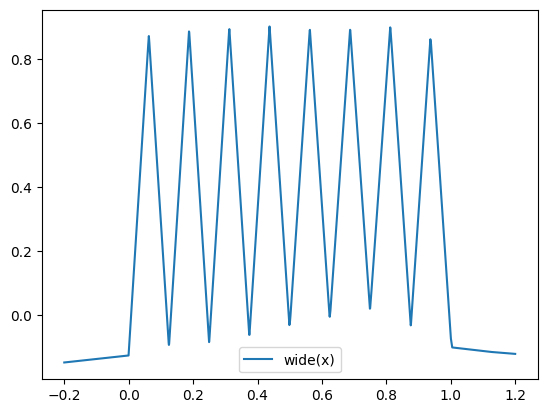

In [4]:
# Create a wide network for lvl=4 and train it
level = 4
n = 2**level + 1
wide = Net(1, n*20)  # a bit more than necessary

# Print the network layers
print(wide)
# Print the number of parameters
print(f'Number of parameters: {sum(p.numel() for p in wide.parameters())}')

x = np.linspace(-0.2, 1.2, 2000)
y = g(x, level)

# Train the network
optimizer = torch.optim.Adam(wide.parameters(), lr=0.02)
for epoch in range(70_000):
    optimizer.zero_grad()
    pred = wide(torch.tensor(x).float().view(-1, 1))
    loss = F.mse_loss(pred, torch.tensor(y).float().view(-1, 1))
    loss.backward()
    optimizer.step()
    if epoch % 10000 == 0:
        print(f'Epoch: {epoch}, loss: {loss.item():.2e}, fc_in W average gradient: {np.mean(wide.fc_in.weight.grad.detach().numpy()):.2e}')

# Plot the result
y = wide(torch.tensor(x).float().view(-1, 1)).detach().numpy()
plt.plot(x, y, label="wide(x)")
plt.legend()
plt.show()

---
#### Deep

Not that many neurons on each layer but many layers:

Net(
  (fc_in): Linear(in_features=1, out_features=5, bias=True)
  (fcs): ModuleList(
    (0-10): 11 x Linear(in_features=5, out_features=5, bias=True)
  )
  (fc_out): Linear(in_features=5, out_features=1, bias=True)
)
Number of parameters: 346
Epoch: 0, loss: 1.11e-01, fc_in W average gradient: 0.00e+00
Epoch: 100, loss: 1.11e-01, fc_in W average gradient: 0.00e+00
Epoch: 200, loss: 1.11e-01, fc_in W average gradient: 0.00e+00
Epoch: 300, loss: 1.11e-01, fc_in W average gradient: 0.00e+00
Epoch: 400, loss: 1.11e-01, fc_in W average gradient: 0.00e+00


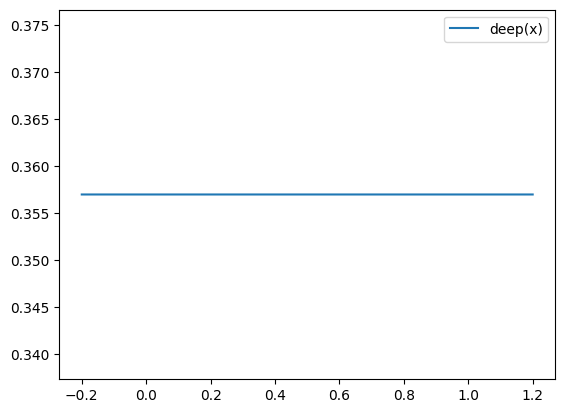

In [5]:
# Create a deep network for level 4 and train it
level = 4
deep = Net(level*3, 5)  # a bit more than necessary

# Print the network layers
print(deep)
# Print the number of parameters
print(f'Number of parameters: {sum(p.numel() for p in deep.parameters())}')

x = np.linspace(-0.2, 1.2, 2000)
y = g(x, level)

# Train the network
optimizer = torch.optim.Adam(deep.parameters(), lr=0.02)
for epoch in range(500):  # pas besoin de beaucoup d'epochs pour se rendre compte que le gradient a vanished
    optimizer.zero_grad()
    pred = deep(torch.tensor(x).float().view(-1, 1))
    loss = F.mse_loss(pred, torch.tensor(y).float().view(-1, 1))
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, loss: {loss.item():.2e}, fc_in W average gradient: {np.mean(deep.fc_in.weight.grad.detach().numpy()):.2e}')

# Plot the result
y = deep(torch.tensor(x).float().view(-1, 1)).detach().numpy()
plt.plot(x, y, label="deep(x)")
plt.legend()
plt.show()

Look at the gradients! After today's class we can explain what happened last time: *gradient vanishing*.

Let's try and combat the vanishing gradient problem **without removing hidden layers** (as we seen that a deep network is useful because it allows us to have much less parameters to attain the global minimum (theoretically)).

---
Let's try to use a **Leaky ReLU activation function**.

In [6]:
class LeakyNet(nn.Module):
    def __init__(self, n_layers=1, n_hidden=3):
        super(LeakyNet, self).__init__()
        self.fc_in = nn.Linear(1, n_hidden)
        self.fcs = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for i in range(n_layers-1)])
        self.fc_out = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc_in(x), negative_slope=0.1)
        for i in range(len(self.fcs)):
            x = F.leaky_relu(self.fcs[i](x), negative_slope=0.1)
        x = self.fc_out(x)
        return x

LeakyNet(
  (fc_in): Linear(in_features=1, out_features=5, bias=True)
  (fcs): ModuleList(
    (0-10): 11 x Linear(in_features=5, out_features=5, bias=True)
  )
  (fc_out): Linear(in_features=5, out_features=1, bias=True)
)
Number of parameters: 346
Epoch: 0, loss: 5.18e-01, fc_in W average gradient: 1.76e-08


Epoch: 100, loss: 8.27e-02, fc_in W average gradient: -4.82e-03
Epoch: 200, loss: 5.82e-02, fc_in W average gradient: -1.09e-02
Epoch: 300, loss: 5.69e-02, fc_in W average gradient: -1.08e-02
Epoch: 400, loss: 5.54e-02, fc_in W average gradient: -9.74e-03


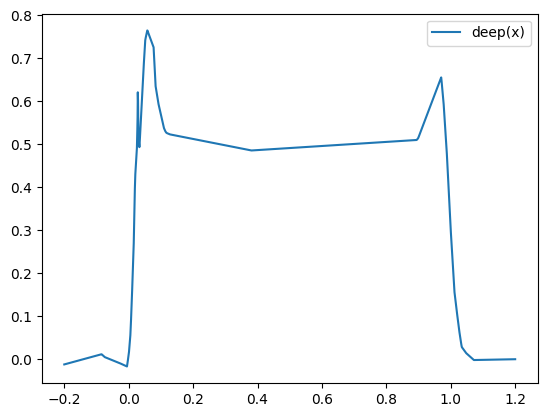

In [7]:
# Create a deep network for level 4 and train it
level = 4
deep = LeakyNet(level*3, 5)

# Print the network layers
print(deep)
# Print the number of parameters
print(f'Number of parameters: {sum(p.numel() for p in deep.parameters())}')

x = np.linspace(-0.2, 1.2, 2000)
y = g(x, level)

# Train the network
optimizer = torch.optim.Adam(deep.parameters(), lr=0.02)
for epoch in range(500):
    optimizer.zero_grad()
    pred = deep(torch.tensor(x).float().view(-1, 1))
    loss = F.mse_loss(pred, torch.tensor(y).float().view(-1, 1))
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, loss: {loss.item():.2e}, fc_in W average gradient: {np.mean(deep.fc_in.weight.grad.detach().numpy()):.2e}')

# Plot the result
y = deep(torch.tensor(x).float().view(-1, 1)).detach().numpy()
plt.plot(x, y, label="deep(x)")
plt.legend()
plt.show()

It's a lot better! It's not the only time we see this, it allows the gradients to not be exactly stuck at 0 (cf. very end of TD 1 in which all the neurons were in the negative part of the ReLU function).

---
Let's try **residual connections** now, because LeakyRelu isn't the only way to combat vanishing gradients.

In [8]:
class ResidualNet(nn.Module):
    def __init__(self, n_layers=1, n_hidden=3):
        super(ResidualNet, self).__init__()
        self.fc_in = nn.Linear(1, n_hidden)
        self.fcs = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for i in range(n_layers-1)])
        self.fc_out = nn.Linear(n_hidden, 1)

    def forward(self, x):
        res = x
        x = F.relu(self.fc_in(x))
        for i in range(len(self.fcs)):
            x = F.relu(self.fcs[i](x)) + res
        x = self.fc_out(x) + res
        return x

ResidualNet(
  (fc_in): Linear(in_features=1, out_features=5, bias=True)
  (fcs): ModuleList(
    (0-10): 11 x Linear(in_features=5, out_features=5, bias=True)
  )
  (fc_out): Linear(in_features=5, out_features=1, bias=True)
)
Number of parameters: 346
Epoch: 0, loss: 1.07e+00, fc_in W average gradient: -3.22e-09


Epoch: 100, loss: 7.93e-02, fc_in W average gradient: 0.00e+00
Epoch: 200, loss: 6.09e-02, fc_in W average gradient: 0.00e+00
Epoch: 300, loss: 6.00e-02, fc_in W average gradient: 0.00e+00
Epoch: 400, loss: 5.96e-02, fc_in W average gradient: 0.00e+00


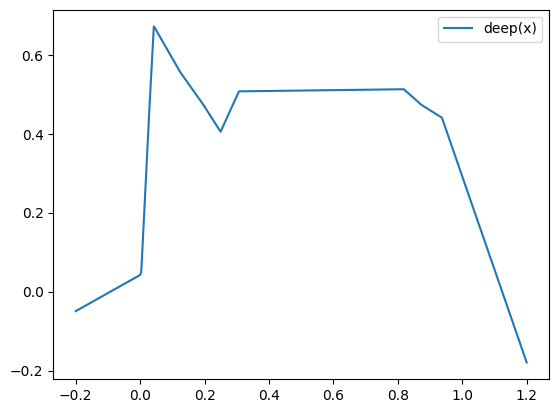

In [9]:
# Create a deep network for level 4 and train it
level = 4
deep = ResidualNet(level*3, 5)

# Print the network layers
print(deep)
# Print the number of parameters
print(f'Number of parameters: {sum(p.numel() for p in deep.parameters())}')

x = np.linspace(-0.2, 1.2, 2000)
y = g(x, level)

# Train the network
optimizer = torch.optim.Adam(deep.parameters(), lr=0.02)
for epoch in range(500):
    optimizer.zero_grad()
    pred = deep(torch.tensor(x).float().view(-1, 1))
    loss = F.mse_loss(pred, torch.tensor(y).float().view(-1, 1))
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch: {epoch}, loss: {loss.item():.2e}, fc_in W average gradient: {np.mean(deep.fc_in.weight.grad.detach().numpy()):.2e}')

# Plot the result
y = deep(torch.tensor(x).float().view(-1, 1)).detach().numpy()
plt.plot(x, y, label="deep(x)")
plt.legend()
plt.show()

It does seem to help, same amount of parameters but cleaner function! You can see that the gradient is stuck at 0 though, it's probably because we don't have enough neurons on each layer so if we're unfortunate and Ax+b is negative or 0 on one entier layer (only 5 neurons per layer here so not that unlikely), the gradient will be stuck at 0...

- Keep in mind we only ran it for 500 epochs whilst we run the wide neural network for 75,000.
- Keep in mind we are displaying an average of gradients (only on one layer) which doesn't really mean anything except when it's exactly 0 like in the initial case for the `deep` network.

---
Alright, so all good! Everything makes sense, now let's actually train the network and let's combine the two methods previously encountered.
Keep in mind we haven't changed the number of parameters!

In [10]:
class ResidualLeakyNet(nn.Module):
    def __init__(self, n_layers=1, n_hidden=3):
        super(ResidualLeakyNet, self).__init__()
        self.fc_in = nn.Linear(1, n_hidden)
        self.fcs = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for i in range(n_layers-1)])
        self.fc_out = nn.Linear(n_hidden, 1)

    def forward(self, x):
        res = x
        x = F.leaky_relu(self.fc_in(x))
        for i in range(len(self.fcs)):
            x = F.leaky_relu(self.fcs[i](x)) + res
        x = self.fc_out(x) + res
        return x

ResidualLeakyNet(
  (fc_in): Linear(in_features=1, out_features=5, bias=True)
  (fcs): ModuleList(
    (0-10): 11 x Linear(in_features=5, out_features=5, bias=True)
  )
  (fc_out): Linear(in_features=5, out_features=1, bias=True)
)
Number of parameters: 346
Epoch: 0, loss: 3.20e-01, fc_in W average gradient: 6.25e-04


Epoch: 10000, loss: 2.37e-02, fc_in W average gradient: -1.51e-02
Epoch: 20000, loss: 9.61e-03, fc_in W average gradient: 5.73e-03
Epoch: 30000, loss: 4.78e-04, fc_in W average gradient: -8.33e-04
Epoch: 40000, loss: 7.58e-04, fc_in W average gradient: -5.30e-03
Epoch: 50000, loss: 1.72e-04, fc_in W average gradient: 1.87e-03
Epoch: 60000, loss: 1.41e-03, fc_in W average gradient: 5.46e-03


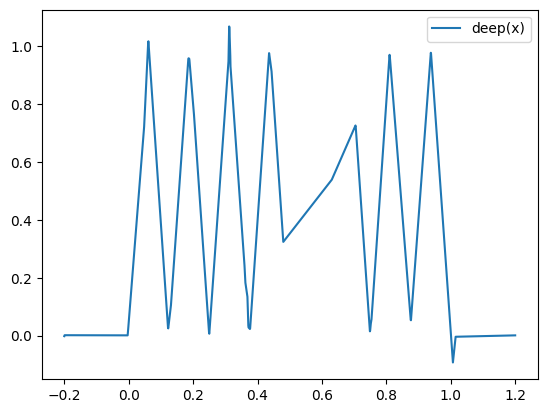

In [11]:
# Create a deep network for level 4 and train it
level = 4
deep = ResidualLeakyNet(level*3, 5)

# Print the network layers
print(deep)
# Print the number of parameters
print(f'Number of parameters: {sum(p.numel() for p in deep.parameters())}')

x = np.linspace(-0.2, 1.2, 2000)
y = g(x, level)

# Train the network
optimizer = torch.optim.Adam(deep.parameters(), lr=0.02)
for epoch in range(70_000):
    optimizer.zero_grad()
    pred = deep(torch.tensor(x).float().view(-1, 1))
    loss = F.mse_loss(pred, torch.tensor(y).float().view(-1, 1))
    loss.backward()
    optimizer.step()
    if epoch % 10000 == 0:
        print(f'Epoch: {epoch}, loss: {loss.item():.2e}, fc_in W average gradient: {np.mean(deep.fcs[-1].weight.grad.detach().numpy()):.2e}')

# Plot the result
y = deep(torch.tensor(x).float().view(-1, 1)).detach().numpy()
plt.plot(x, y, label="deep(x)")
plt.legend()
plt.show()

---
One last technique is often cited to help with the vanishing gradient problem: **batch normalization**.

Note: it adds two parameters* for each batch normalization layer: among other things the mean and variance of the batch, which are used to normalize the activations. These parameters are typically learned during the training process, just like the weights of a linear layer. But the benefits of batch normalization are a lot more than what you'd get by adding a few neurons to your network. As explained in Lecture 3, the reasons why batch normalization work are not fully understood yet.

\* unless you set affine=False in the batch normalization layer, which is not recommended.

In [12]:
class BatchNormalizationResidualLeakyNet(nn.Module):
    def __init__(self, n_layers=1, n_hidden=3):
        super(BatchNormalizationResidualLeakyNet, self).__init__()
        self.fc_in = nn.Linear(1, n_hidden)
        self.batch_norm_in = nn.BatchNorm1d(n_hidden)
        self.fcs = nn.ModuleList([nn.Sequential(nn.Linear(n_hidden, n_hidden), nn.BatchNorm1d(n_hidden)) for i in range(n_layers-1)])
        self.fc_out = nn.Linear(n_hidden, 1)  # no batch normalization on the last layer

    def forward(self, x):
        res = x
        x = F.leaky_relu(self.batch_norm_in(self.fc_in(x)), negative_slope=0.1)
        for i in range(len(self.fcs)):
            x = F.leaky_relu(self.fcs[i][1](self.fcs[i][0](x)), negative_slope=0.1) + res
        x = self.fc_out(x) + res
        return x

In [13]:
# Print the number of parameters of the previous network deep
print(f'Number of parameters of the previous network deep: {sum(p.numel() for p in deep.parameters())}')

# Create a deep network for level 4
level = 4
deep = BatchNormalizationResidualLeakyNet(level*3, 5)
# Print the number of parameters of the new network deep
print(f'Number of parameters of the new network deep: {sum(p.numel() for p in deep.parameters())}')
print(deep)

Number of parameters of the previous network deep: 346
Number of parameters of the new network deep: 466
BatchNormalizationResidualLeakyNet(
  (fc_in): Linear(in_features=1, out_features=5, bias=True)
  (batch_norm_in): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fcs): ModuleList(
    (0-10): 11 x Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fc_out): Linear(in_features=5, out_features=1, bias=True)
)


How many new parameters? 120 new parameters, because we have 12 layers with 5 neurons (i.e. $12*5*2$).

Epoch: 0, loss: 3.29e-01, fc_in W average gradient: -5.35e-03


Epoch: 10000, loss: 1.45e-04, fc_in W average gradient: -6.55e-04
Epoch: 20000, loss: 2.08e-05, fc_in W average gradient: -1.19e-04
Epoch: 30000, loss: 1.25e-04, fc_in W average gradient: -7.60e-04
Epoch: 40000, loss: 3.45e-05, fc_in W average gradient: -6.26e-05
Epoch: 50000, loss: 4.09e-05, fc_in W average gradient: -2.00e-04
Epoch: 60000, loss: 2.43e-05, fc_in W average gradient: 6.52e-05


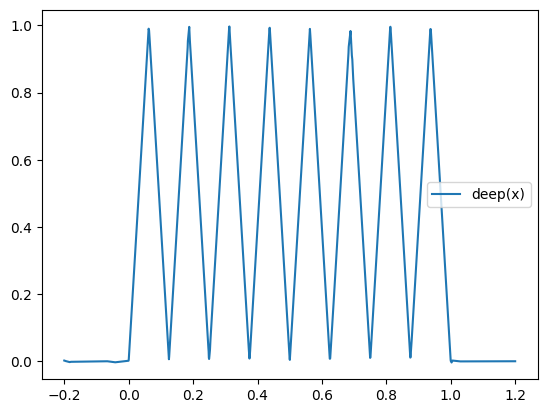

In [14]:
# Let's train our new network

x = np.linspace(-0.2, 1.2, 2000)
y = g(x, level)

# Train the network
optimizer = torch.optim.Adam(deep.parameters(), lr=0.02)
for epoch in range(70_000):
    optimizer.zero_grad()
    pred = deep(torch.tensor(x).float().view(-1, 1))
    loss = F.mse_loss(pred, torch.tensor(y).float().view(-1, 1))
    loss.backward()
    optimizer.step()
    if epoch % 10000 == 0:
        print(f'Epoch: {epoch}, loss: {loss.item():.2e}, fc_in W average gradient: {np.mean(deep.fcs[-1][-1].weight.grad.detach().numpy()):.2e}')

# Plot the result
y = deep(torch.tensor(x).float().view(-1, 1)).detach().numpy()
plt.plot(x, y, label="deep(x)")
plt.legend()
plt.show()

Obviously it all comes back to choosing good hyperparameters (using residual connections or not, batch normalization or not are hyperparameters in itself), but knowing what happens can help understanding how the hyperparameters should be changed. It's impossible to always get it right (so we test everything on big compuetrs) but some rules are obvious ... e.g., if you've got a vanishing gradient problem, please do not add hidden layers ... That's what will differentiate good deep learning engineers from you know ... less experienced ones.

Here the obvious solution would've been to have a network with less hidden layers, and more neurons per layer without increasing the number of parameters to the huge number we need in the wide network. The deep network was obviously 'too deep' and not 'wide enough' for the problem at hand.